In [35]:
import scipy.io as sio
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import copy

import sys
sys.path.append("../")
import data_helpers

In [36]:
tires = ["r25b_16x7-5_10x8","r25b_16x7-5_10x7","r25b_18x7-5_10x7","r25b_18x6_10x6","r25b_16x6_10x7","r25b_16x6_10x6",
        "r25b_18x7-5_10x8","r25b_18x7-5_10x7",
        "LCO_16x7-5_10x8","LCO_16x7-5_10x7","LCO_18x7-5_10x7","LCO_18x6_10x6","LCO_16x6_10x7", "LCO_16x6_10x6",
        "LCO_18x7-5_10x8","LCO_18x7-5_10x7"]

sweeps = ["initial_default", "post_default"]
tire_coeffs = {}
for tire in tires:
    tire_coeffs[tire] = {sweep:{"lateral_mus":[], "long_mus":[]} for sweep in sweeps}

camber = 0 # default camber
pressure = 12* 6.89476 # default pressure
velocity = 25 * 1.60934 # default velocity
long_slip_angle = 0 # default slip angle for long
SA_cutoff = 8 # degrees, where slip occurs
SR_cutoff = 0.1 # %, where slip occurs

load_lateral = np.array([-250, -200, -150, -100, -50]) / 0.224809
load_long = np.array([-250, -200, -150, -50]) / 0.224809

# metric is something such as "SL" or "SA"
# output is something such as "NFX" or "NFY"
# lower is the absolute value lower bound of the metric
def get_normal_mus(df, normal_loads, lower, metric, output):
    return_mus = []
    for x in normal_loads:
        load_df = df[(df["load"] == x) & ((df[metric] < -1*lower) | (df[metric] > lower))]
        return_mus.append(load_df[output].abs().mean()*0.6)
    return return_mus

In [37]:
### LATERAL CALCS ###
for tire in tires:
    try:
        df = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/cornering_hoosier_{0}.mat".format(tire)))
    except:
        # data hasnt been filtered yet (or doesnt exist)
        continue

    run_ids = df["RUN"].unique()
    initial_df = df[((df["velocity"] == velocity) & (df["pressure"] == pressure) & (df["camber"] == camber) & (df["RUN"] == run_ids[0]))]
    initial_mus = get_normal_mus(initial_df, load_lateral, SA_cutoff, "SA", "NFY")
    tire_coeffs[tire]["initial_default"]["lateral_mus"] = initial_mus

    # find if there is an post sweep
    if len(run_ids) > 1:
        post_df = df[((df["velocity"] == velocity) & (df["pressure"] == pressure) & (df["camber"] == camber) & (df["RUN"] == run_ids[1]))]
        post_mus = get_normal_mus(initial_df, load_lateral, SA_cutoff, "SA", "NFY")
        tire_coeffs[tire]["post_default"]["lateral_mus"] = post_mus

In [38]:
### LONG CALCS ###
for tire in tires:
    try:
        df = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/braking_hoosier_{0}.mat".format(tire)))
    except:
        # data not filtered / doesnt exist
        continue
    
    run_ids = df["RUN"].unique()
    initial_df = df[((df["slip"] == long_slip_angle) & (df["pressure"] == pressure) & (df["camber"] == camber) & (df["RUN"] == run_ids[0]))]
    initial_mus = get_normal_mus(initial_df, load_long, SR_cutoff, "SL", "NFX")
    tire_coeffs[tire]["initial_default"]["long_mus"] = initial_mus

    # find if there is an post sweep
    if len(run_ids) > 1:
        post_df = df[((df["slip"] == long_slip_angle) & (df["pressure"] == pressure) & (df["camber"] == camber) & (df["RUN"] == run_ids[1]))]
        post_mus = get_normal_mus(initial_df, load_long, SR_cutoff, "SL", "NFX")
        tire_coeffs[tire]["post_default"]["long_mus"] = post_mus

Text(0.5, 1.0, 'Long MU vs Lateral MU')

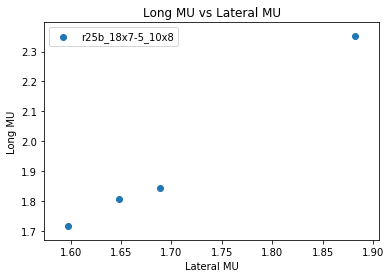

In [41]:
for name,data in tire_coeffs.items():
    if len(data["initial_default"]["lateral_mus"]) > 0 and len(data["initial_default"]["long_mus"]) > 0 :
        la_mu = data["initial_default"]["lateral_mus"][:3] + [data["initial_default"]["lateral_mus"][4]]
        lo_mu = data["initial_default"]["long_mus"]
        plt.scatter(la_mu, lo_mu, label = name)
plt.legend()
plt.xlabel("Lateral MU")
plt.ylabel("Long MU")
plt.title("Long MU vs Lateral MU")